In [1]:
suppressMessages(library("rwwa"))

In [2]:
gmst <- read.table("data/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

In [3]:
pi <- read.csv("ts/pi-nov_era5.csv")
sst <- read.csv("ts/sst-nov_era5.csv")

In [4]:
# observed anomaly
sst[sst$year == 2025,"sst"]

[1] 29.03255

In [5]:
sst[sst$year == 2025,"sst"] - mean(sst[(sst$year >= 1990) & (sst$year <= 2020),"sst"])

[1] 0.2177126

In [15]:
mean(sst[(sst$year >= 1990) & (sst$year <= 2020),"sst"])


[1] 28.81484

In [6]:
df <- merge(gmst, merge(pi, sst))

df <- df[df$year >= 1950,]

cov_f <- df[df$year == 2025,"gmst",drop = F]
cov_cf <- cov_f - 1.3

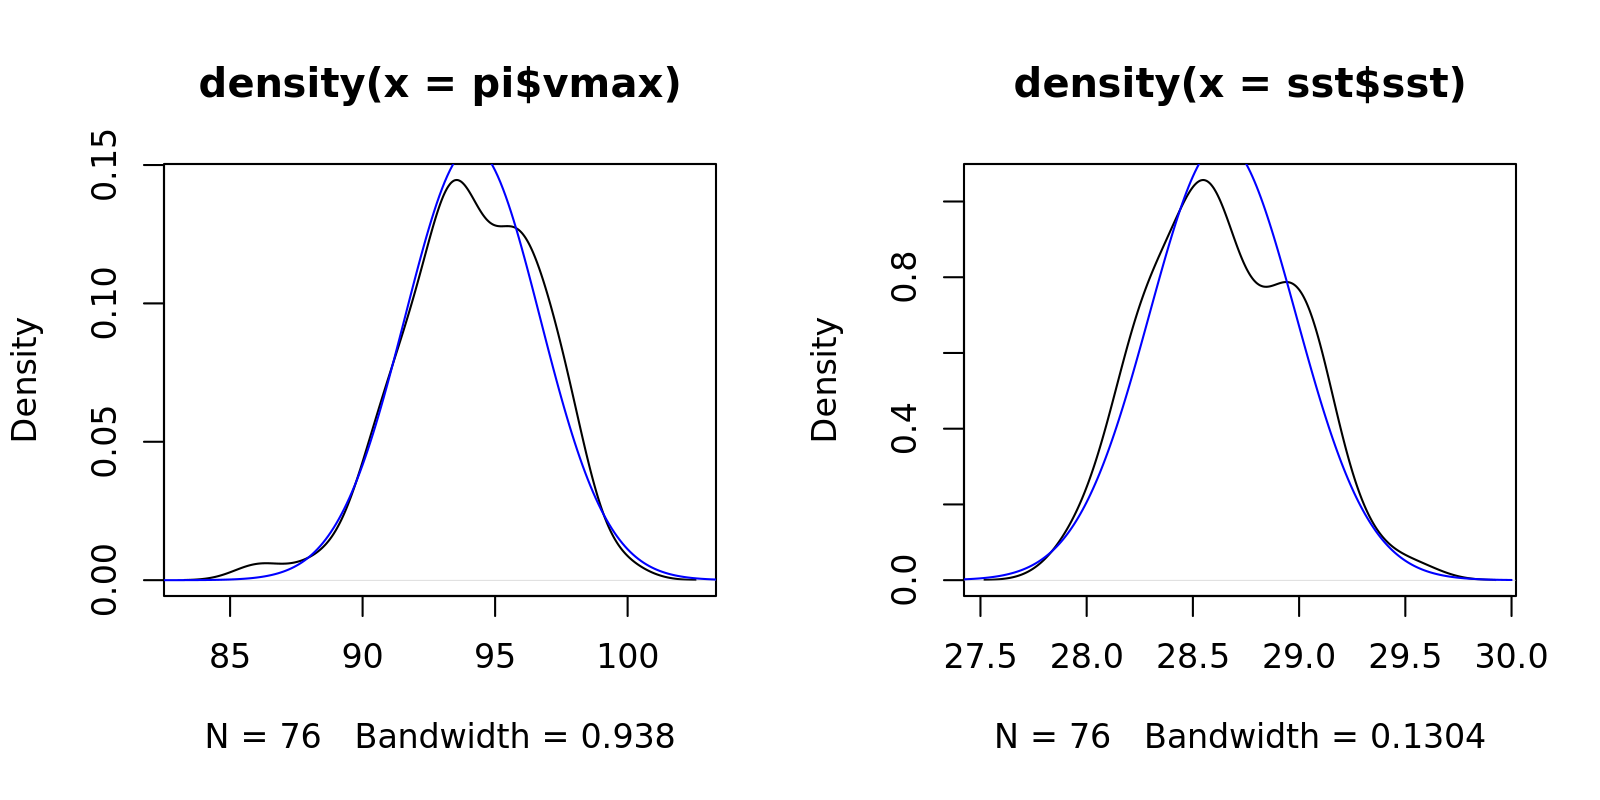

In [7]:
prep_window(c(1,2))

plot(density(pi$vmax))
lines(x <- seq(80,105,0.1), dnorm(x, mean(pi$vmax), sd(pi$vmax)), col = "blue")

plot(density(sst$sst))
lines(x <- seq(25,30,0.01), dnorm(x, mean(sst$sst), sd(sst$sst)), col = "blue")

In [18]:
mdl_pi <- fit_ns("norm", "shift", df, covnm = "gmst", varnm = "vmax")
mdl_sst <- fit_ns("norm", "shift", df, covnm = "gmst", varnm = "sst")

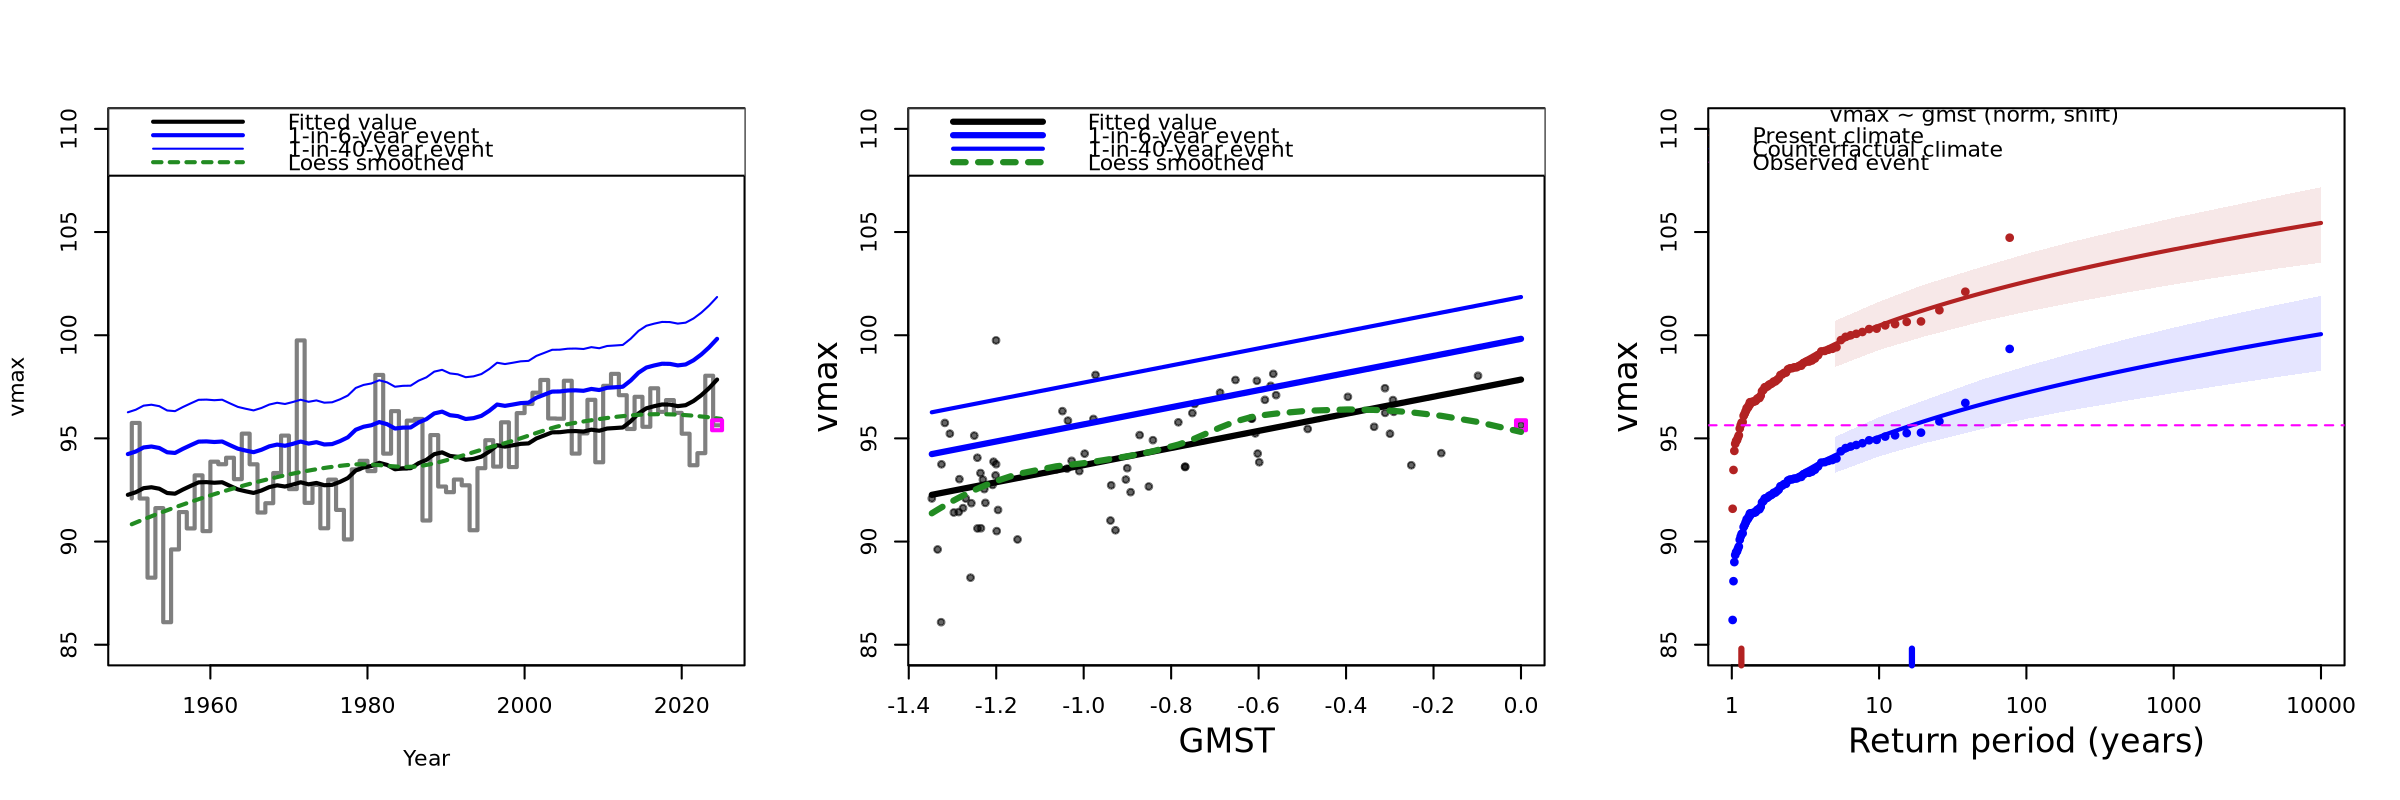

In [19]:
prep_window(c(1,3))
ylim <- c(85,110)

plot_trend(mdl_pi, ylim = ylim)
plot_covtrend(mdl_pi, "gmst", ylim = ylim)
plot_returnlevels(mdl_pi, cov_f = cov_f, cov_cf = cov_cf, ylim = ylim)

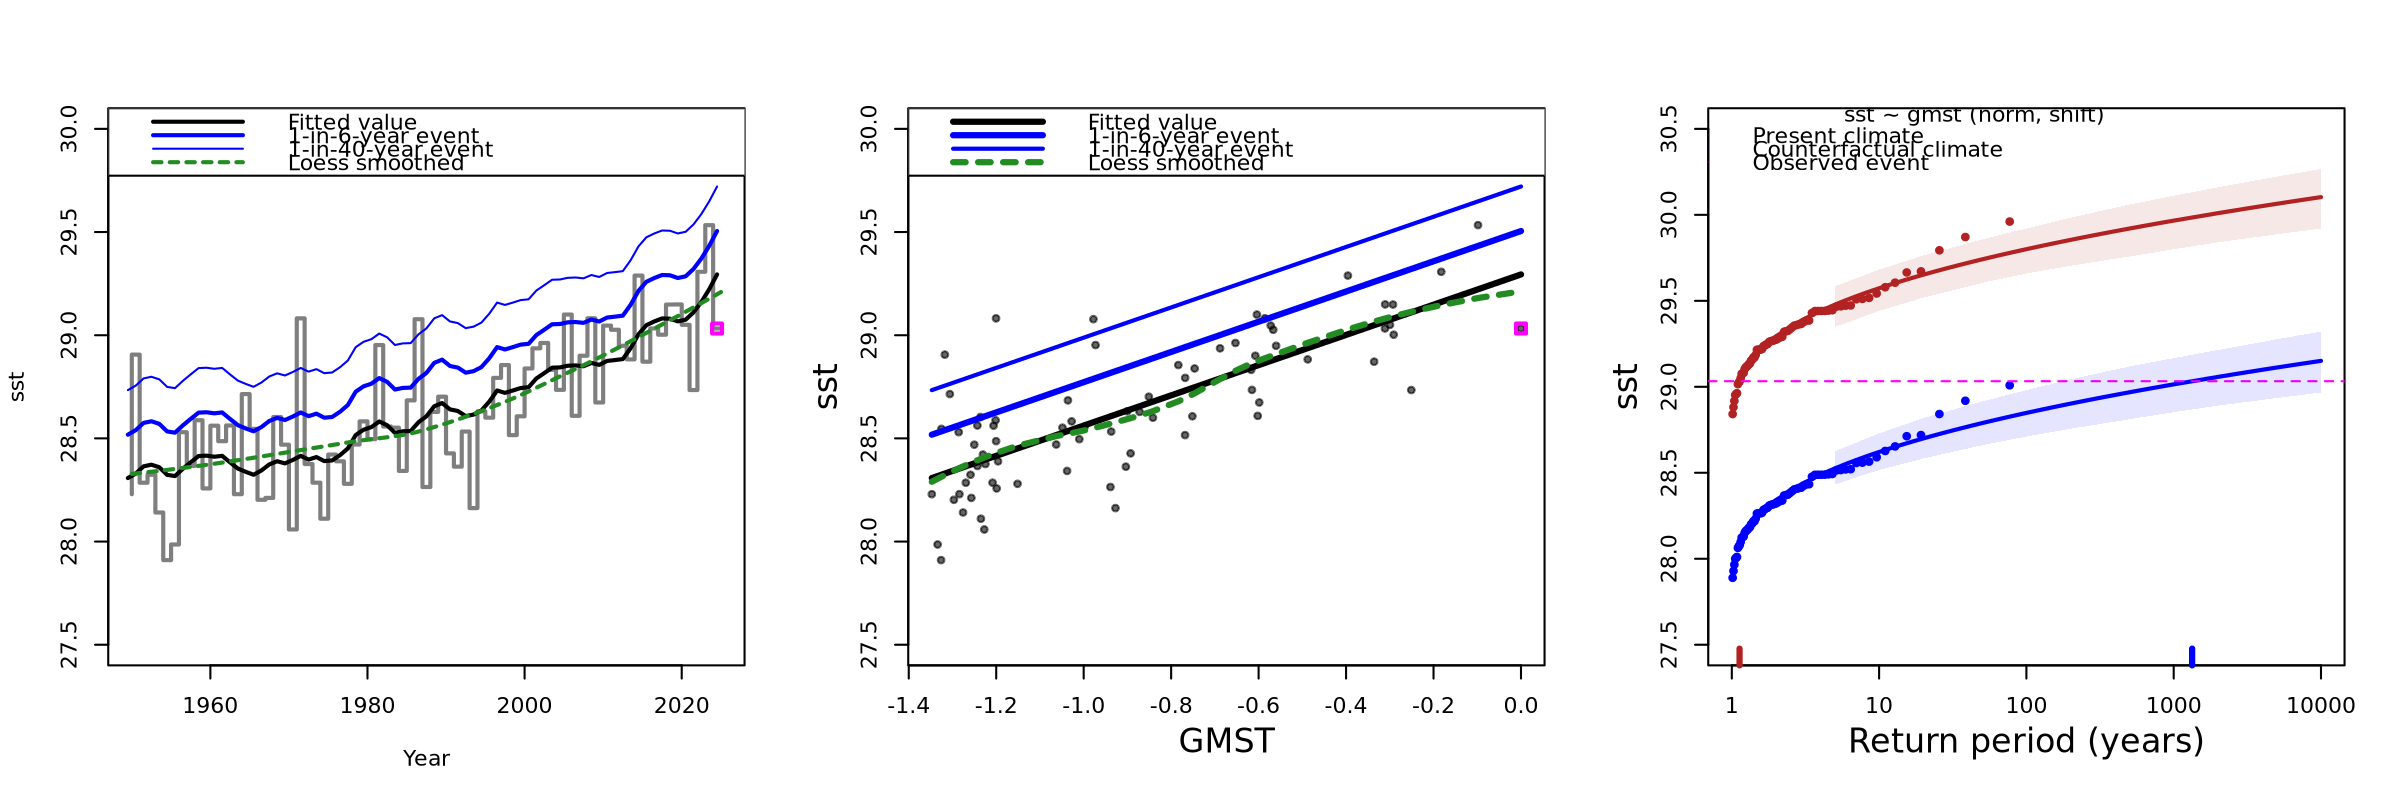

In [20]:
prep_window(c(1,3))

plot_trend(mdl_sst)
plot_covtrend(mdl_sst, "gmst")
plot_returnlevels(mdl_sst, cov_f = cov_f, cov_cf = cov_cf)

In [21]:
signif(cbind(rbind("PI" = mdl_ests(mdl_pi, cov_f = cov_f, cov_cf = cov_cf), 
            "SST" = mdl_ests(mdl_sst, cov_f = cov_f, cov_cf = cov_cf)),
             "rp_pi" = rbind(return_period(mdl_pi, mdl_pi$ev, fixed_cov = cov_cf), return_period(mdl_sst, mdl_sst$ev, fixed_cov = cov_cf))), 2)

,mu0,sigma0,alpha_gmst,disp,event_magnitude,return_period,PR,dI_abs,dI_rel,aic,
PI,98,2.00,4.10,0.0210,96,1.2,14,5.40,6.0,330,17
SST,29,0.22,0.73,0.0074,29,1.1,1200,0.95,3.4,-10,1300


## Check effect of IOD & Nino

In [11]:
nino <- read.csv("~/00_WWA_project_folder/ephemeral/SEAsiaFloods/datfiles-obs/nino_son.csv", col.names = c("year", "nino"))
iod <- load_ts("~/00_WWA_project_folder/ephemeral/SEAsiaFloods/datfiles-obs/iod_son.dat", col.names = c("year", "iod"))
gmst <- read.table("data/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

pi <- read.csv("ts/pi-nov_era5.csv")
sst <- read.csv("ts/sst-nov_era5.csv")

df <- merge(merge(gmst, merge(pi, sst)), merge(iod, nino))
df <- df[df$year >= 1950,]

cov_f <- df[df$year == 2025,c("gmst", "iod", "nino"),drop = F]
cov_cf <- rbind("pi" = cov_f - c(1.3,0,0),
                "neut" = c(cov_f[,"gmst"],0,0))

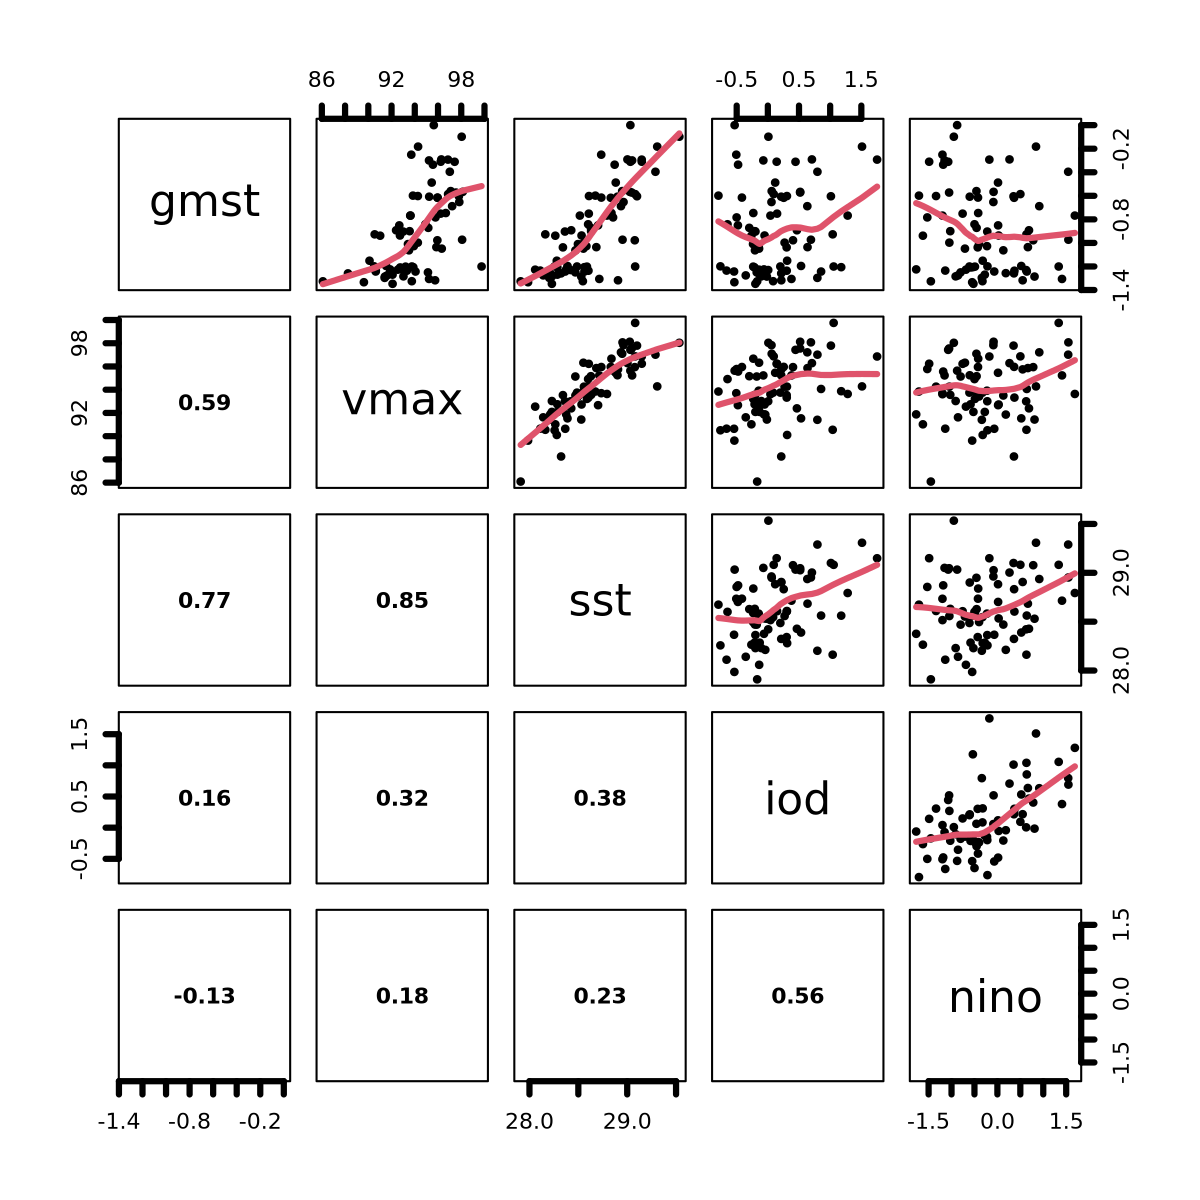

In [12]:
prep_window(h = 6, w = 6)
pairs(df[,-1], lower.panel = panel.cor, upper.panel = panel.smooth, lwd = 3)

In [13]:
mdl_pi <- list("GMST only" = fit_ns("norm", "shift", df, covnm = "gmst", varnm = "vmax"),
               "GMST + Nino" = fit_ns("norm", "shift", df, covnm = c("gmst", "nino"), varnm = "vmax"),
               "GMST + IOD" = fit_ns("norm", "shift", df, covnm = c("gmst", "iod"), varnm = "vmax"),
               "GMST + Nino + IOD" = fit_ns("norm", "shift", df, covnm = c("gmst", "nino", "iod"), varnm = "vmax"))

mdl_sst <- list("GMST only" = fit_ns("norm", "shift", df, covnm = "gmst", varnm = "sst"),
                "GMST + Nino" = fit_ns("norm", "shift", df, covnm = c("gmst", "nino"), varnm = "sst"),
                "GMST + IOD" = fit_ns("norm", "shift", df, covnm = c("gmst", "iod"), varnm = "sst"),
                "GMST + Nino + IOD" = fit_ns("norm", "shift", df, covnm = c("gmst", "nino", "iod"), varnm = "sst"))

In [14]:
sapply(mdl_pi, function(mdl) c("aic" = aic(mdl), rsquared(mdl)))
sapply(mdl_sst, function(mdl) c("aic" = aic(mdl), rsquared(mdl)))

,GMST only,GMST + Nino,GMST + IOD,GMST + Nino + IOD
aic,330.1254913,323.4148107,325.9721733,324.4856565
r2,0.3496679,0.4200923,0.4002467,0.4271389
r2.adj,0.3408796,0.4042044,0.3838151,0.4032697


,GMST only,GMST + Nino,GMST + IOD,GMST + Nino + IOD
aic,-10.2628594,-32.6672621,-22.5849972,-32.4284149
r2,0.5965126,0.7073333,0.6658146,0.7140373
r2.adj,0.5910601,0.6993150,0.6566588,0.7021221


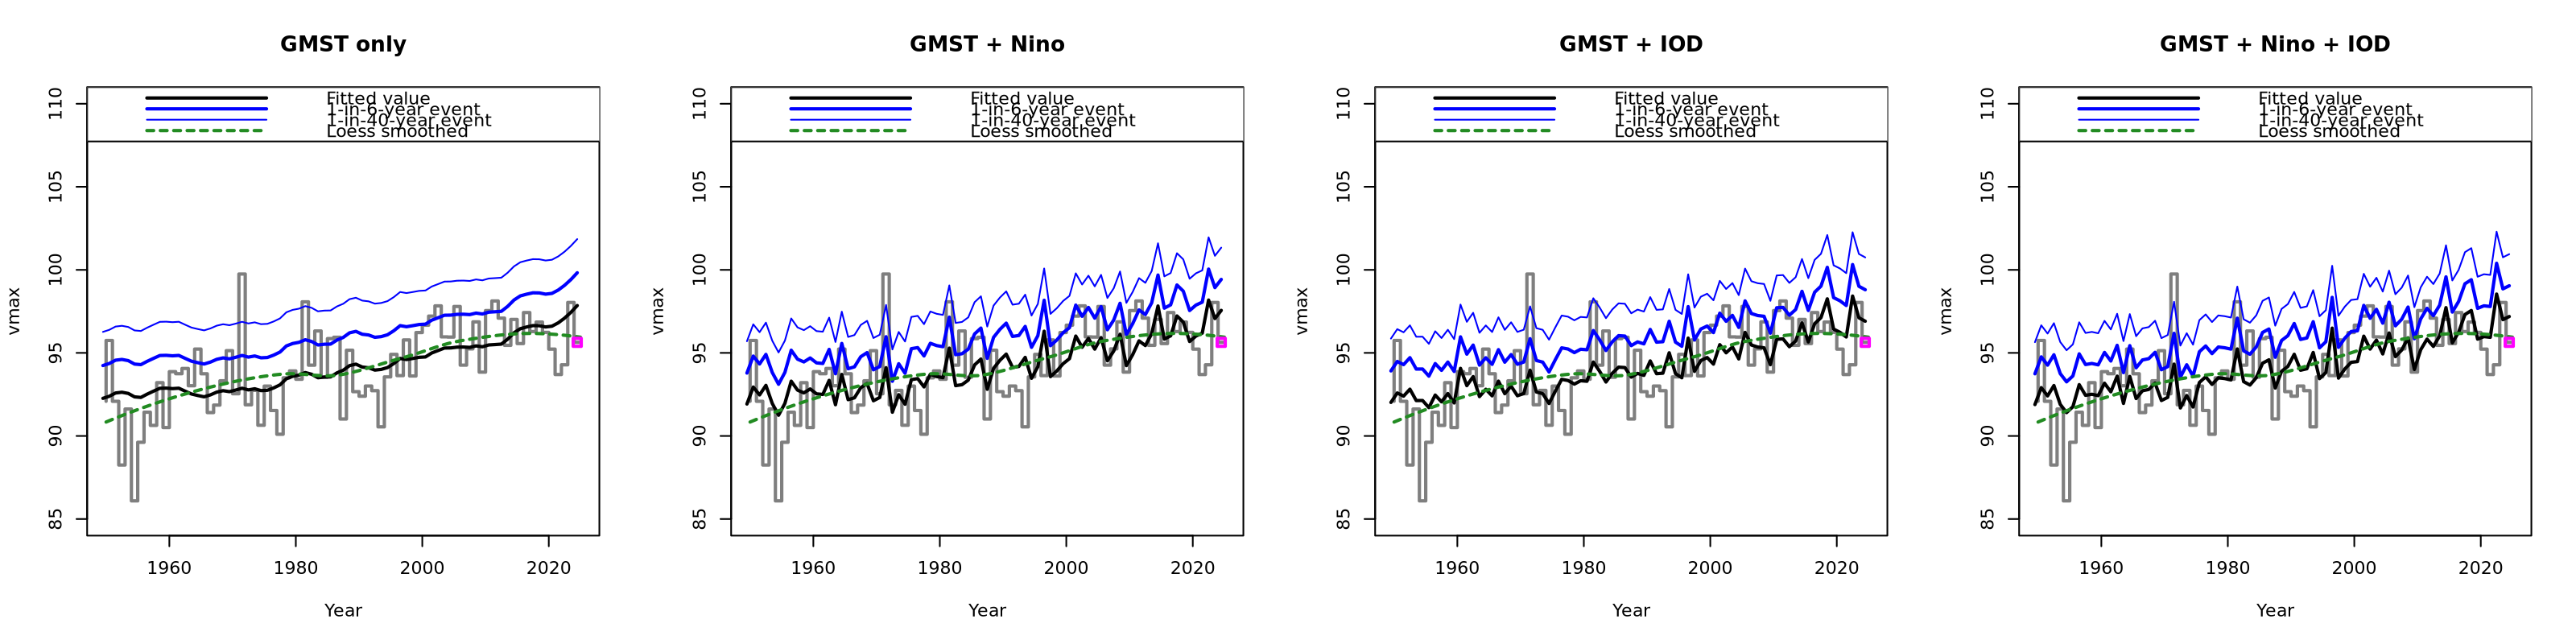

In [26]:
prep_window(c(1,4))

for (i in 1:4) {
    plot_trend(mdl_pi[[i]], ylim = c(85,110), main = names(mdl_pi)[i])
}

In [27]:
ests_pi <- rbind.fill(sapply(mdl_pi, function(mdl) data.frame(t(mdl_ests(mdl, cov_f = cov_f, cov_cf = cov_cf))), simplify = F))
rownames(ests_pi) <- names(mdl_pi)
ests_pi <- cbind(ests_pi, t(round(sapply(mdl_pi, rsquared), 2))[,1,drop = F])
signif(ests_pi[,order(colnames(ests_pi))], 3)

,aic,alpha_gmst,alpha_iod,alpha_nino,dI_abs_neut,dI_abs_pi,dI_rel_neut,dI_rel_pi,disp,event_magnitude,mu0,PR_neut,PR_pi,r2,return_period,sigma0
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GMST only,330,4.15,NA,NA,0.000,5.39,0.000,5.97,0.0209,95.6,97.9,1.000,14.4,0.35,1.16,2.04
GMST + Nino,323,4.40,NA,0.828,-0.726,5.72,-0.754,6.36,0.0198,95.6,98.3,0.919,34.5,0.42,1.19,1.93
GMST + IOD,326,3.90,1.090,NA,-0.580,5.07,-0.603,5.59,0.0202,95.6,97.5,0.896,28.0,0.40,1.35,1.96
GMST + Nino + IOD,324,4.23,0.505,0.635,-0.826,5.49,-0.856,6.09,0.0197,95.6,98.0,0.886,39.8,0.43,1.26,1.92


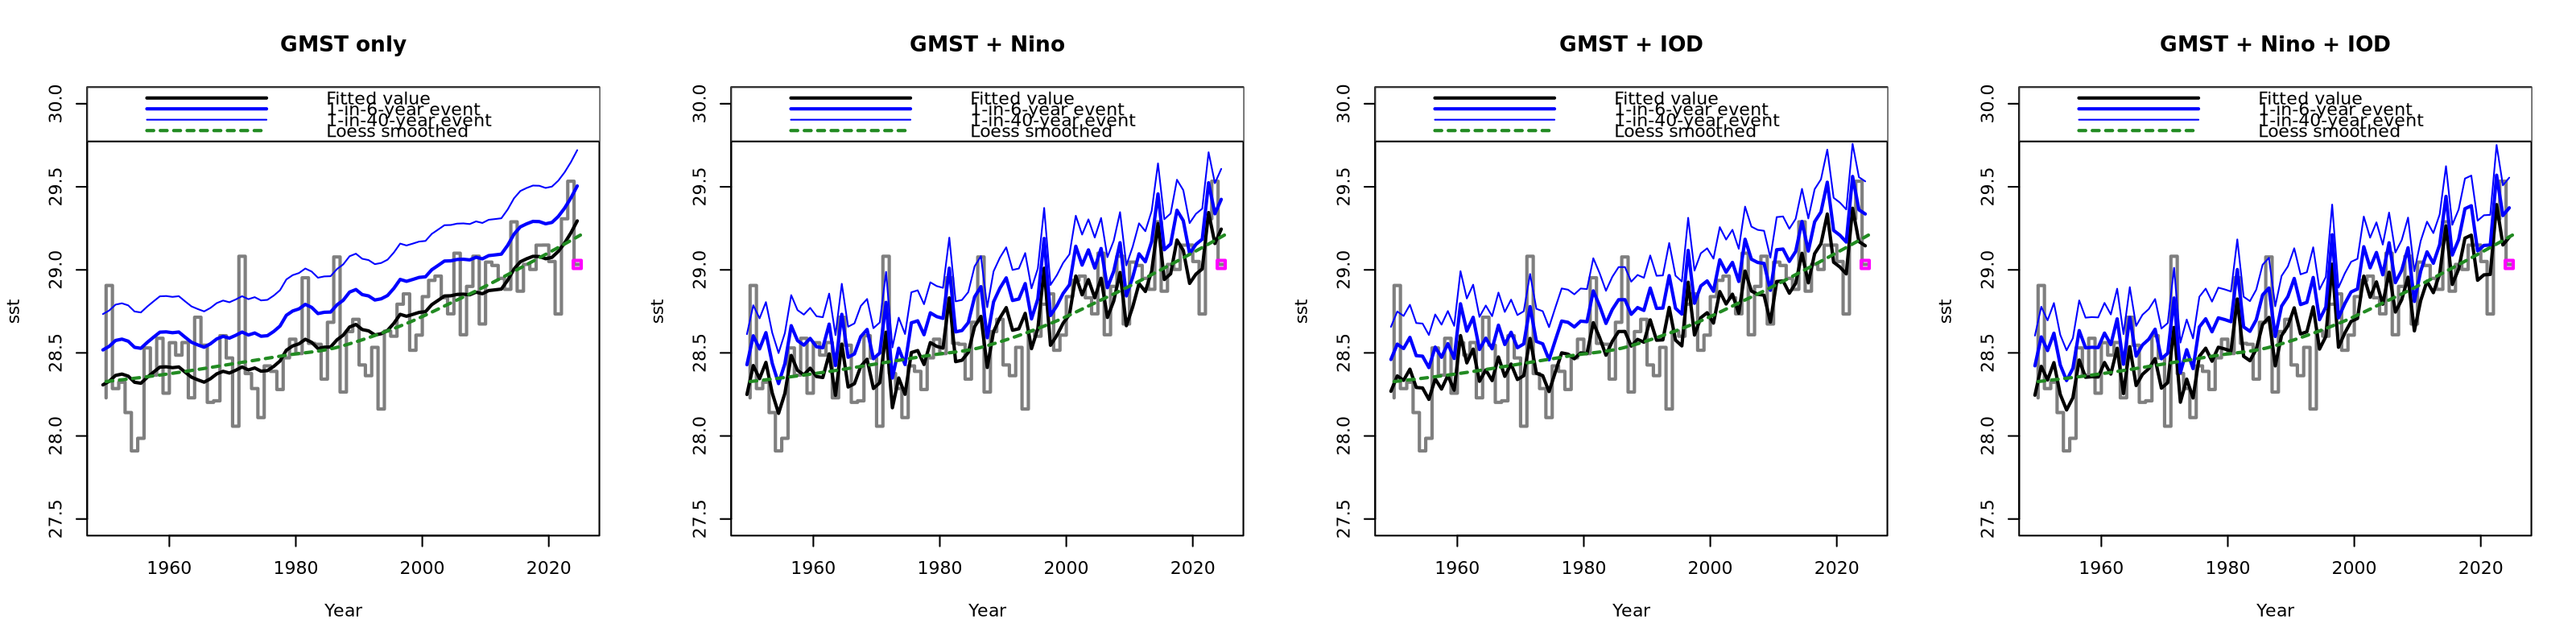

In [28]:
prep_window(c(1,4))

for (i in 1:4) {
    plot_trend(mdl_sst[[i]], main = names(mdl_sst)[i])
}

In [29]:
ests_sst <- rbind.fill(sapply(mdl_sst, function(mdl) data.frame(t(mdl_ests(mdl, cov_f = cov_f, cov_cf = cov_cf))), simplify = F))
rownames(ests_sst) <- names(mdl_sst)
ests_sst <- cbind(ests_sst, t(round(sapply(mdl_sst, rsquared), 2))[,1,drop = F])
signif(ests_sst[,order(colnames(ests_sst))], 3)

,aic,alpha_gmst,alpha_iod,alpha_nino,dI_abs_neut,dI_abs_pi,dI_rel_neut,dI_rel_pi,disp,event_magnitude,mu0,PR_neut,PR_pi,r2,return_period,sigma0
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GMST only,-10.3,0.733,NA,NA,0.0000,0.952,0.000,3.39,0.00742,29,29.3,1.000,1180,0.60,1.13,0.217
GMST + Nino,-32.7,0.776,NA,0.140,-0.1230,1.010,-0.422,3.60,0.00633,29,29.4,0.906,101000,0.71,1.14,0.185
GMST + IOD,-22.6,0.693,0.1720,NA,-0.0918,0.901,-0.315,3.20,0.00679,29,29.2,0.842,21000,0.67,1.40,0.198
GMST + Nino + IOD,-32.4,0.752,0.0665,0.115,-0.1360,0.978,-0.467,3.49,0.00627,29,29.3,0.858,189000,0.71,1.23,0.183


## Bootstrapped model results

In [59]:
boot_res <- sapply(mdl_sst, boot_ci, cov_f = cov_f, cov_cf = cov_cf, nsamp = 1000, simplify = F)

In [60]:
# bootstrap rsquared as well
set.seed(42)
boot_rsq <- sapply(mdl_sst, function(mdl) {
    rsq <- list()
    i <- 1
    f <- 0
    while (length(rsq) < 1000) {
        boot_df <- mdl$data[sample(1:nrow(mdl$data), replace = T), 
            ]
        tryCatch({
            boot_mdl <- refit(mdl, new_data = boot_df)
            rsq[[i]] <- rsquared(boot_mdl)[1]
            i <- i + 1
        }, error = function(cond) {
            f <- f + 1
            return(NULL)
        })
    }
    quantile(unlist(rsq), c(0.025, 0.975))
}, simplify = F)

In [ ]:
rsq <- rbind("est" = sapply(mdl_sst, rsquared)["r2",], data.frame(boot_rsq)) * 100

In [66]:
boot_tbl <- sapply(names(boot_res), function(rnm) rbind(boot_res[[rnm]], t(setNames(rsq[,gsub("\\+| ", ".", rnm), drop = F], "r2"))))

In [58]:
invisible(sapply(names(boot_res), function(rnm) write.csv(rbind(boot_res[[rnm]], t(setNames(rsq[,gsub("\\+| ", ".", rnm), drop = F], "r2"))),
                                                          paste0("res/res-sst_era5_",gsub(" ", "", tolower(rnm)), ".csv"))))

In [67]:
sapply(c("return_period", "PR_pi", "PR_neut", "dI_abs_pi", "dI_abs_neut", "r2"), function(rnm) {
    apply(sapply(boot_tbl, "[", rnm, ), 2, function(r) paste0(signif(as.numeric(r[1]), 2), " (",signif(as.numeric(r[2]), 2), ", ", signif(as.numeric(r[3]), 2), ")"))
})

,return_period,PR_pi,PR_neut,dI_abs_pi,dI_abs_neut,r2
GMST only,"1.1 (1, 1.4)","1200 (140, 70000)","1 (1, 1)","0.95 (0.76, 1.1)","0 (0, 0)","60 (44, 74)"
GMST + Nino,"1.1 (1, 1.4)","1e+05 (4200, 6.1e+07)","0.91 (0.78, 0.98)","1 (0.85, 1.2)","-0.12 (-0.18, -0.07)","71 (59, 81)"
GMST + IOD,"1.4 (1.1, 2.1)","21000 (960, 5700000)","0.84 (0.66, 0.97)","0.9 (0.73, 1.1)","-0.092 (-0.15, -0.039)","67 (52, 79)"
GMST + Nino + IOD,"1.2 (1, 1.7)","190000 (4700, 4.3e+08)","0.86 (0.68, 0.97)","0.98 (0.83, 1.1)","-0.14 (-0.2, -0.074)","71 (58, 82)"


In [ ]:
boot_res[[4]]

In [ ]:
png("fig/trendplot_sst-era5_gmstonly.png", height = 400, width = 400); {
    prep_window(mar = c(4.1,4.1,0.3,0.1), lwd = 2, cex = 1.3)
    plot_trend(mdl_sst$"GMST only", xlab = "", ylab = "November SST (°C)")
}; dev.off()

In [57]:
sapply(boot_res, "[", 

,est,2.5%,97.5%
mu0,2.929456e+01,2.917304e+01,2.941851e+01
sigma0,2.174159e-01,1.750130e-01,2.544030e-01
alpha_gmst,7.325093e-01,5.867360e-01,8.730717e-01
disp,7.421717e-03,5.966952e-03,8.692430e-03
event_magnitude,2.903255e+01,2.903255e+01,2.903255e+01
return_period,1.128779e+00,1.024520e+00,1.372906e+00
PR_pi,1.181831e+03,1.366681e+02,7.009986e+04
dI_abs_pi,9.522621e-01,7.627568e-01,1.134993e+00
dI_rel_pi,3.391212e+00,2.698133e+00,4.068432e+00
PR_neut,1.000000e+00,1.000000e+00,1.000000e+00


In [15]:
df$fitted_gmst <- ns_pars(mdl_sst[[1]])$loc

In [16]:
# how much lower than expected are we?
diff(unlist(df[df$year == 2025,c("sst", "fitted_gmst")]))

fitted_gmst 
  0.2620026

In [23]:
mean(df$fitted_gmst[(df$year >= 1990) & (df$year <= 2020)])

[1] 28.82751

In [25]:
df$fitted_gmst[df$year == 2025] - mean(df$fitted_gmst[(df$year >= 1990) & (df$year <= 2020)])

[1] 0.4670434